# Slyper Preprocessing

Script follows the preprocessing workflow provided by the scBestPractices online textbook for processing of scRNAseq datasets for downstream analysis.

Adapted for use on Kildesiute NB dataset prior to dataset integration.

### Packages

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import pathlib
import glob
import os 
import seaborn as sns
import scipy
import rpy2
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation

In [3]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.figdir = '/project/data/gew123/Processed_h5ad/Figures'
sc.settings.set_figure_params(dpi=80, facecolor='white')

2024-06-05 12:55:30.936520: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 12:55:32.515743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.23.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


### Load raw data

In [4]:
# Setting file paths
raw_data = '/project/data/gew123/Raw_h5ad/Slyper_raw.h5ad'
processed_data = '/project/data/gew123/Processed_h5ad/Slyper_processed.h5ad'
figures = '/project/data/gew123/Processed_h5ad/Figures'
dataset = 'Slyper'

In [5]:
#Read in data
adata = sc.read_h5ad(raw_data)

## Preprocessing
### Quality Control

Low number of detected genes, low count depth and high fraction of mitochondrial counts indicates a dying cell 

Need to define cell quality control (QC) threshold for identifying and filtering out dying cells; Cell QC is typically performed on the following three covariates:

1. Number of counts per barcode (count depth)

2. Number of genes per barcode

3. Fraction of counts from mitochondrial genes per barcode

In [6]:
adata

AnnData object with n_obs × n_vars = 2211840 × 33694
    obs: 'Slyper'

In [7]:
# Immediately filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

filtered out 2186333 cells that have less than 200 genes expressed


normalizing counts per cell
    finished (0:00:00)


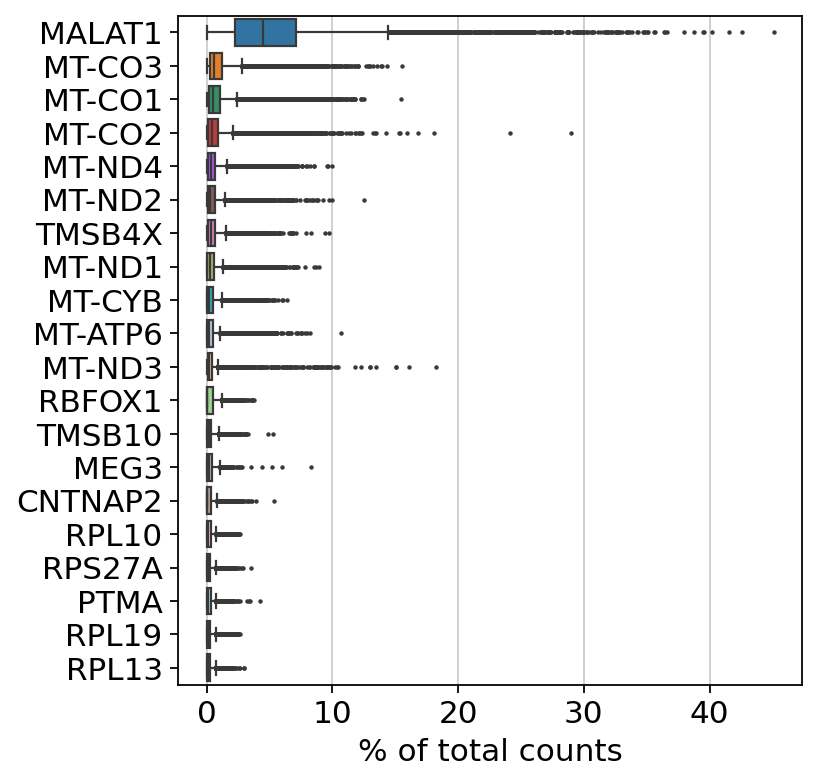

In [33]:
# Show genes with highest fraction of counts in each cell when normalized across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

Filtering out of (1) mitochondrial genes, (2) cells with low gene counts, (3) genes with low count depth

In [8]:
# Subset mitochondrial genes 
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# Hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [9]:
# Filter out by mt, ribo, & hb genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

# Check
adata

AnnData object with n_obs × n_vars = 25507 × 33694
    obs: 'Slyper', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

.var / .obs metrics:

- `n_genes_by_counts` in `.obs` = number of genes with positive counts in a cell,

- `total_counts` = total number of counts for a cell, this might also be known as library size, and

- `pct_counts_mt` = proportion of total counts for a cell which are mitochondrial.

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


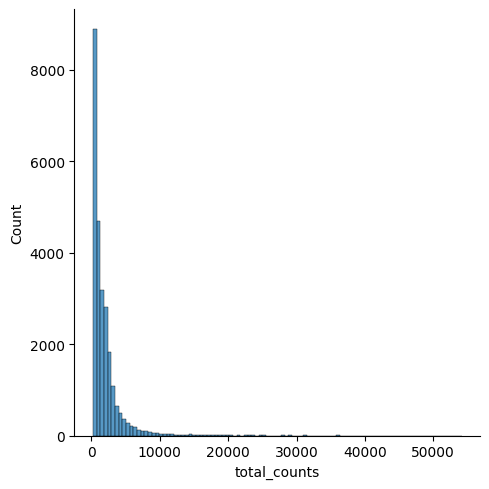

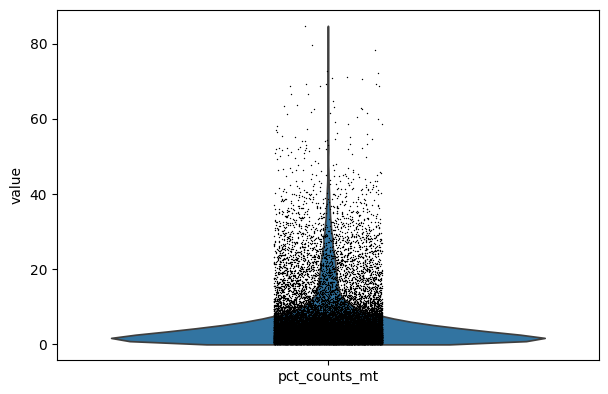

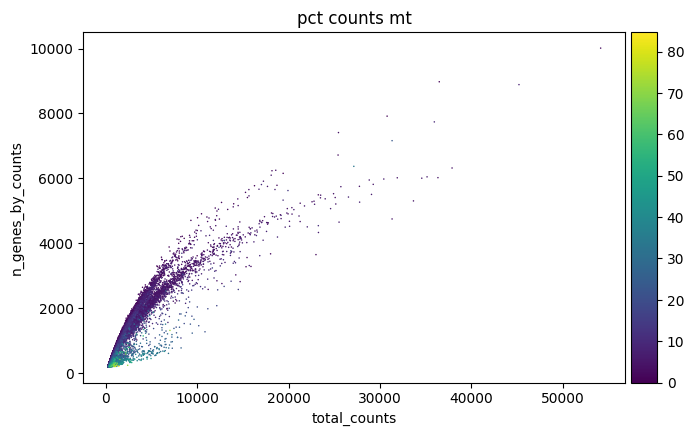

In [9]:
# Plot 3 QC covariates respectively
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Can now define threshold either manual or automatically for filtering out cells:

In [10]:
## Automated (performed better than manual):
# Define function to take in filtering metric
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


# Apply to QC covariates each with a threshold of 5 MADs ### why 5??????? check
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print("Low quality cells:")
print(adata.obs.outlier.value_counts(), '\n')

# Filter out cells with MT count greater than 8%
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)

print("Cells with high mitochondrial gene expression:")
print(adata.obs.mt_outlier.value_counts())

Low quality cells:
False    23425
True      2082
Name: outlier, dtype: int64 

Cells with high mitochondrial gene expression:
False    20700
True      4807
Name: mt_outlier, dtype: int64


In [11]:
## Automated (cont.):
# Filter cells based on low quality / high mit count

print('Filtering cells...\n')
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Filtering cells...

Total number of cells: 25507
Number of cells after filtering of low quality cells: 20628


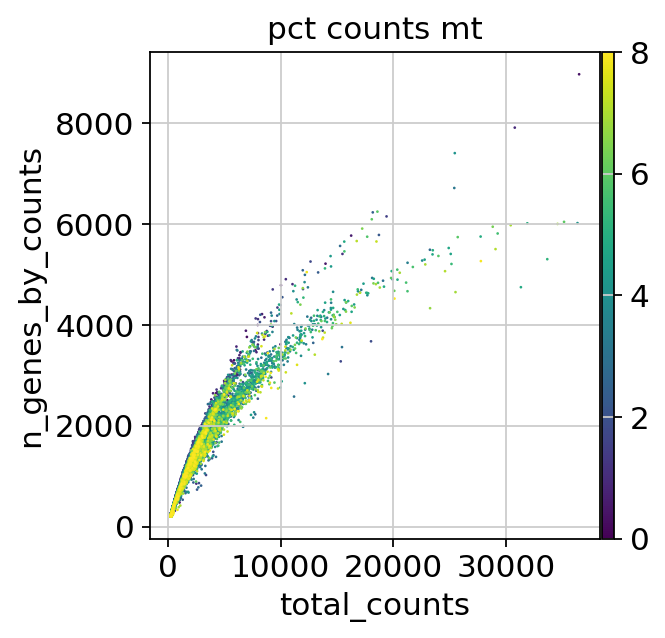

In [14]:
# Plot to confirm sufficient filtering threshold was applied
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_slyper_MT_count.png")

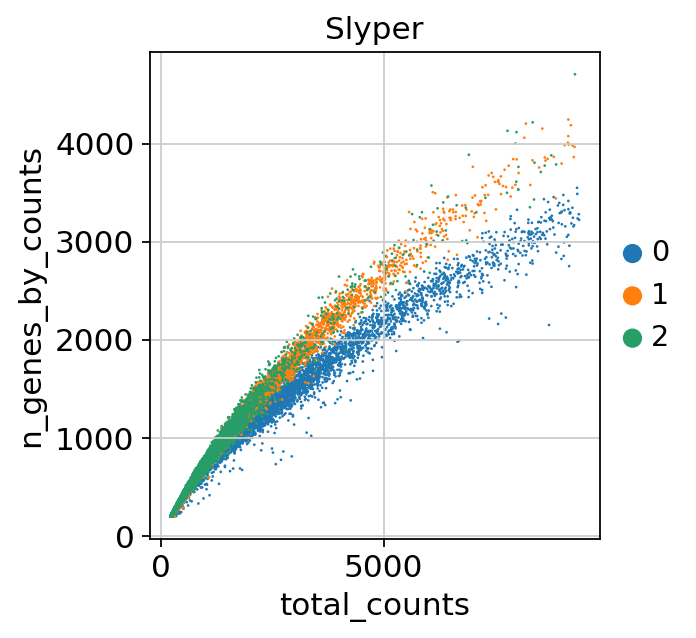

In [69]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="Slyper", save="_slyper_MT_count_by_sample.png")
# Still looks a little high for MT count - compare to other datasets? 

In [123]:
adata

AnnData object with n_obs × n_vars = 20628 × 33694
    obs: 'Slyper', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Normalisation

3 different methods:
- Shifted logarithm transformation
- scran normalisation (requires R)
- Analytic approximation of Pearson residuals

Shifted log works better for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes

Scran was extensively tested and used for batch correction tasks

Analytic Pearson residuals are well suited for selecting biologically variable genes and identification of rare cell types

* Note: For the sake of time and simplicity, will use **shifted logarithm transformation** for normalisation of all datasets

In [13]:
# Get scaled counts
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)

# Perform transformation
adata.layers["log1p"] = sc.pp.log1p(scales_counts["X"], copy=True)

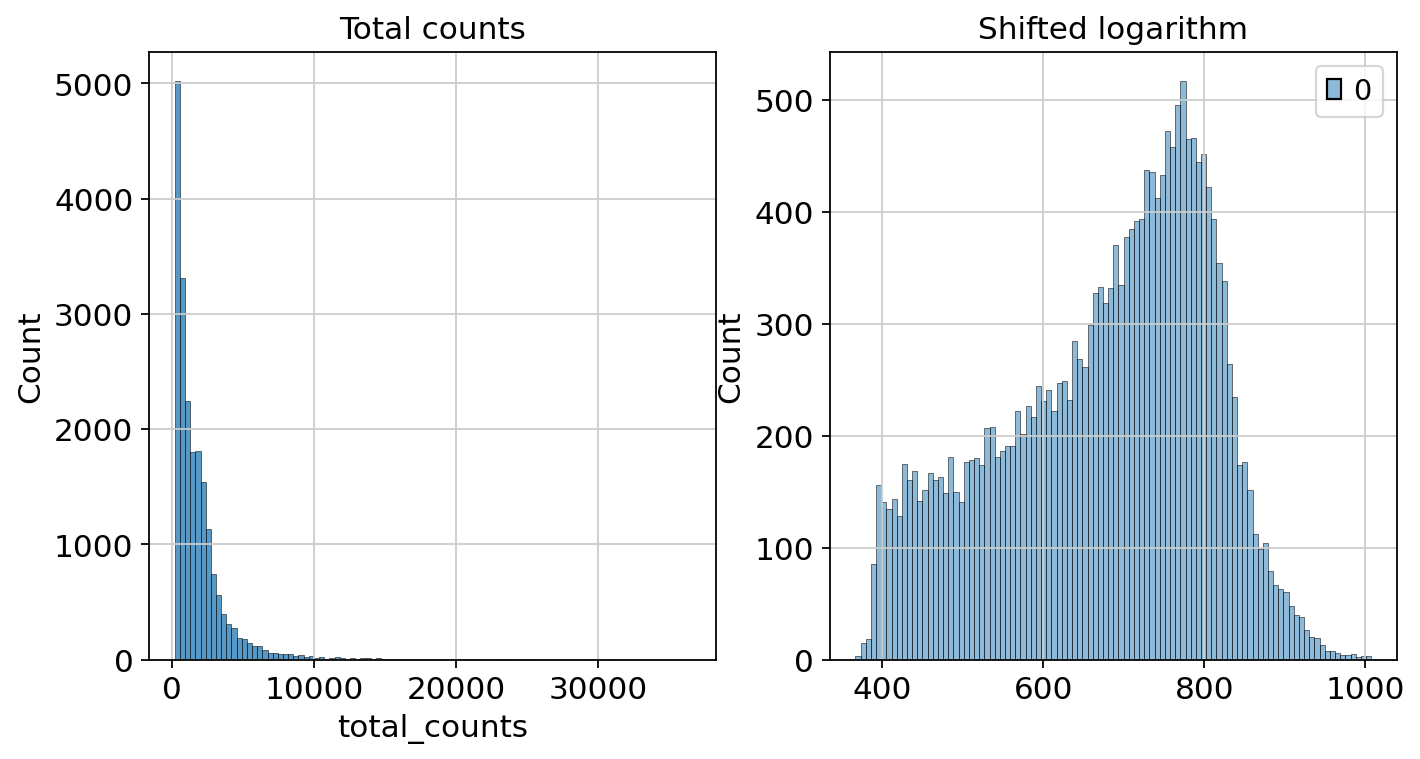

<Figure size 320x320 with 0 Axes>

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot before normalisation
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
plt.savefig(f'{figures}/Slyper_raw.png', bbox_inches='tight')

# Plot after normalisation
log1p_sum = adata.layers["log1p"].sum(axis=1)
p2 = sns.histplot(log1p_sum, bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()
plt.savefig(f'{figures}/Slyper_log.png', bbox_inches='tight')


In [19]:
adata.layers['log1p']

<20628x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 21804350 stored elements in Compressed Sparse Row format>

In [76]:
adata.X

<20321x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 20504630 stored elements in Compressed Sparse Row format>

In [27]:
# Check layers
adata.layers

Layers with keys: log1p

In [77]:
# Save processed file
adata.write(processed_data)

In [78]:
# Check filter genes counts
sc.pp.filter_genes(adata, min_cells=3)

filtered out 7681 genes that are detected in less than 3 cells
